In [1]:
from pathlib import Path
import os
import sys

import matplotlib.pyplot as plt

main_directory = Path(os.path.abspath("")).parent
benchmark_directory = Path(main_directory, "experiment_scripts", "benchmarks")
sys.path.append(str(main_directory))

## Load The Benchmarking Results

In [2]:
from experiment_scripts.benchmark_result_serialization import ResultDecoder, VQABenchmarkResult, EVQEBenchmarkResult
from json import load

def load_benchmarking_results(algorithm: str, experiment_name: str):
    result_folder = Path(benchmark_directory, algorithm, experiment_name)
    
    result_dict: dict[int, dict[int, list]] = dict()
    
    size_folders = result_folder.glob("*")
    sizes = list(int(folder.stem) for folder in size_folders)
    
    for size in sizes:
        sub_dict = dict()
        
        instance_folders = result_folder.glob(f"{size}/*")
        instances = list(int(folder.stem) for folder in instance_folders)
        
        for instance in instances:
            result_list = []
            
            result_files = result_folder.glob(f"{size}/{instance}/*")
            for result in result_files:
                with open(result) as f:
                    result_list.append(load(f, cls=ResultDecoder))
            
            sub_dict[instance] = result_list
        
        result_dict[size] = sub_dict
            
    return result_dict

In [3]:
evqe_loaded = load_benchmarking_results("evqe", experiment_name="2205_1")
qaoa_loaded = load_benchmarking_results("qaoa", experiment_name="2205_1")
vqe_loaded = load_benchmarking_results("vqe", experiment_name="2205_1")

In [218]:
evqe5_loaded = load_benchmarking_results("evqe", experiment_name="2405_5Pop")
evqe20_loaded = load_benchmarking_results("evqe", experiment_name="2405_20Pop")

## Define Performance Metrics

In [6]:
from typing import Union

def p_val(result: Union[VQABenchmarkResult, EVQEBenchmarkResult]) -> float:
    
    probability = 0
    
    if isinstance(result, VQABenchmarkResult):
        for state, prob in result.measurement_distribution.items():
            sol = result.state_translations[state]
            if sol.is_valid:
                probability += prob
    
    if isinstance(result, EVQEBenchmarkResult):
        for state, prob in result.result.eigenstate.items():
            sol = result.state_translations[state]
            if sol.is_valid:
                probability += prob
    
    return probability

In [7]:
from typing import Union

def p_opt(result: Union[VQABenchmarkResult, EVQEBenchmarkResult]) -> float:
    opt_makespan = result.optimal_makespan
    probability = 0
    
    if isinstance(result, VQABenchmarkResult):
        for state, prob in result.measurement_distribution.items():
            sol = result.state_translations[state]
            if sol.makespan is not None and sol.makespan == opt_makespan:
                probability += prob
    
    if isinstance(result, EVQEBenchmarkResult):
        for state, prob in result.result.eigenstate.items():
            sol = result.state_translations[state]
            if sol.makespan is not None and sol.makespan == opt_makespan:
                probability += prob
    
    return probability

In [122]:
from typing import Union

def nexp_term(result: Union[VQABenchmarkResult, EVQEBenchmarkResult]) -> int:
    
    if isinstance(result, VQABenchmarkResult):
        return result.expectation_evaluation_counts[-1]
    
    if isinstance(result, EVQEBenchmarkResult):
        return sum(result.result.circuit_evaluations)

In [21]:
def nexp_best(result: Union[VQABenchmarkResult, EVQEBenchmarkResult]) -> int:
    
    if isinstance(result, VQABenchmarkResult):
        indices = (i for i, val in enumerate(result.expectation_values) if val == result.best_expectation_value)
        first = next(indices)
        return result.expectation_evaluation_counts[first]
    
    if isinstance(result, EVQEBenchmarkResult):
        expectation_values = [r.best_expectation_value for r in result.result.population_evaluation_results]
        indices = (i for i, val in enumerate(expectation_values) if val == result.result.eigenvalue)
        first = next(indices)
        return sum(result.result.circuit_evaluations[:first+1])

In [84]:
from typing import Union, Optional
from numpy import real

def nexp_bounded(result: Union[VQABenchmarkResult, EVQEBenchmarkResult], bound: float) -> Optional[int]:
    
    if isinstance(result, VQABenchmarkResult):
        indices = (i for i, val in enumerate(result.expectation_values) if real(val) < real(bound))
        try:
            first = next(indices)
        except:
            return None
        return result.expectation_evaluation_counts[first]
    
    if isinstance(result, EVQEBenchmarkResult):
        expectation_values = [real(r.best_expectation_value) for r in result.result.population_evaluation_results]
        indices = (i for i, val in enumerate(expectation_values) if val < real(bound))
        try:
            first = next(indices)
        except:
            return None
        return sum(result.result.circuit_evaluations[:first+1])

In [9]:
from typing import Union, Optional

def nexp_bval(result: Union[VQABenchmarkResult, EVQEBenchmarkResult]) -> Optional[int]:
    bound = result.min_penalty
    return nexp_bounded(result, bound)

In [90]:
from typing import Union, Optional

def nexp_bopt(result: Union[VQABenchmarkResult, EVQEBenchmarkResult]) -> Optional[int]:
    bound = result.min_subopt_energy
    return nexp_bounded(result, bound)

## Plot Raw Run History Data

In [258]:
from typing import Optional
from numpy import real

def plot_evqe_runhistory(loaded_results: list[EVQEBenchmarkResult], title: Optional[str] = None, valid_energy_level: Optional[float] = None, opt_energy_level: Optional[float] = None, log_scale: bool = False, savepath: Optional[Path] = None):
    
    for result in loaded_results:
        x = [sum(result.result.circuit_evaluations[:i+1]) for i in range(0, len(result.result.circuit_evaluations))]
        y = [real(x.best_expectation_value) for x in result.result.population_evaluation_results]
        x = x[:len(y)]
        plt.plot(x, y)
    
    plt.xlabel("Expectation Value Evaluations")
    plt.ylabel("Expectation Value")
    
    if title is not None:
        plt.title(title)
    
    if valid_energy_level is not None:
        plt.axhline(y=valid_energy_level, color="r")
    
    if opt_energy_level is not None:
        plt.axhline(y=opt_energy_level, color="b")
    
    if log_scale:
        plt.yscale("log")
    
    if savepath is not None:
        plt.savefig(savepath)

In [295]:
def plot_vqa_runhistory(loaded_results: list[VQABenchmarkResult], title: Optional[str] = None, valid_energy_level: Optional[float] = None, opt_energy_level: Optional[float] = None, log_scale: bool = False, aggregate_n_steps: Optional[int] = None, savepath: Optional[Path] = None):
    for result in loaded_results:
        if aggregate_n_steps is None:
            x = result.expectation_evaluation_counts
            y = result.expectation_values
        else:
            x = result.expectation_evaluation_counts[::aggregate_n_steps]
            y = [min(result.expectation_values[i: i+aggregate_n_steps]) for i in list(range(0, len(result.expectation_values)))[::aggregate_n_steps]]
        plt.plot(x,y, marker='*', linestyle='--')
    
    plt.xlabel("Expectation Value Evaluations")
    plt.ylabel("Expectation Value")
    
    if title is not None:
        plt.title(title)
    
    if valid_energy_level is not None:
        plt.axhline(y=valid_energy_level, color='r')
    
    if opt_energy_level is not None:
        plt.axhline(y=opt_energy_level, color="b")
    
    if log_scale:
        plt.yscale("log")
    
    if savepath is not None:
        plt.savefig(savepath)

In [266]:
val_energy = evqe_loaded[18][8][0].min_penalty
opt_energy = real(evqe_loaded[18][8][0].min_subopt_energy)

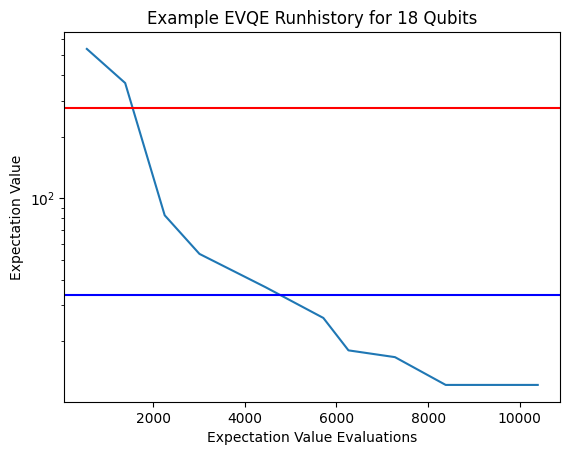

In [319]:
plottable_results = evqe_loaded[18][8][1:2]
savepath = Path(Path(), "evqe_termination_failure.pdf")
plot_evqe_runhistory(plottable_results, title="Example EVQE Runhistory for 18 Qubits", log_scale=True, valid_energy_level=val_energy, opt_energy_level=opt_energy, savepath=savepath)

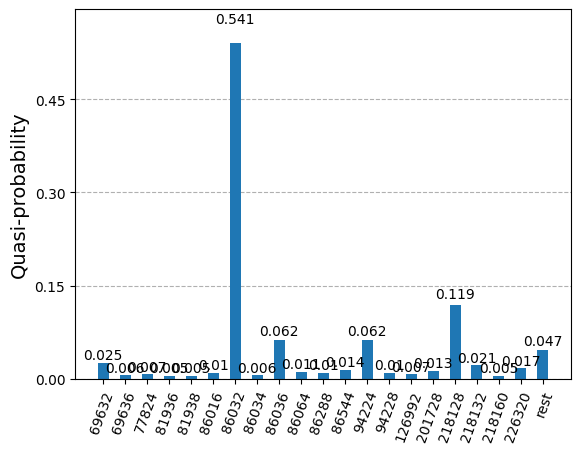

In [8]:
from qiskit.visualization import plot_histogram

eigenstate = plottable_results = evqe_loaded[18][6][0].result.eigenstate
plot_histogram(eigenstate, number_to_keep=20)

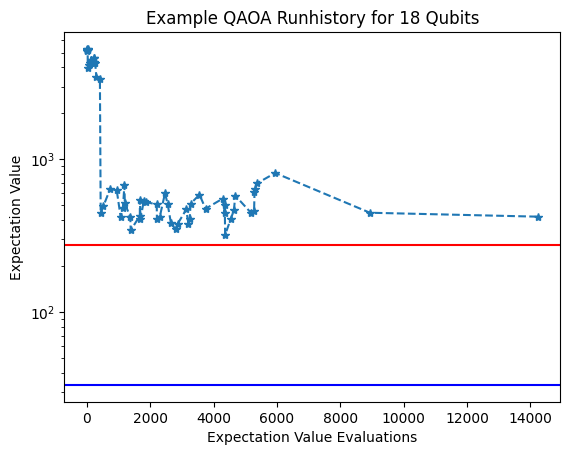

In [296]:
plottable_results = qaoa_loaded[18][8][3:4]
savepath = Path(Path(), "qaoa_termination_failure.pdf")
plot_vqa_runhistory(plottable_results, title="Example QAOA Runhistory for 18 Qubits", log_scale=True, valid_energy_level=val_energy, opt_energy_level=opt_energy, savepath=savepath)

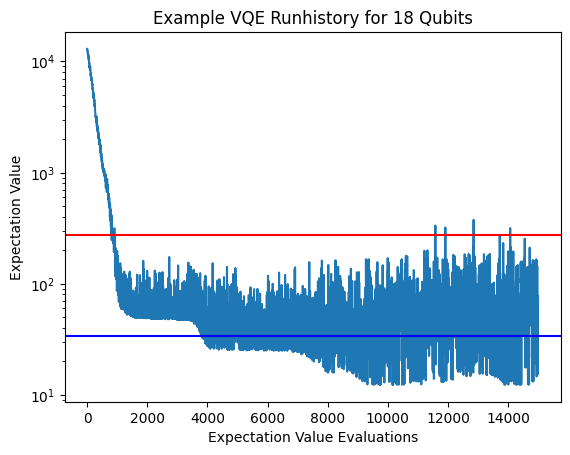

In [282]:
plottable_results = vqe_loaded[18][8][1:2]
savepath = Path(Path(), "vqe_termination_failure.pdf")
plot_vqa_runhistory(plottable_results, title="Example VQE Runhistory for 18 Qubits", log_scale=True, valid_energy_level=val_energy, opt_energy_level=opt_energy, aggregate_n_steps=1, savepath=savepath)

## Plot Inter Instance Differences

In [71]:
from typing import Callable, Union

def compare_measurement_likelihoods(results: dict[int, Union[VQABenchmarkResult, EVQEBenchmarkResult]], metric: Callable[[Union[VQABenchmarkResult, EVQEBenchmarkResult]], float], ylabel: str):
    for instance, instance_results in results.items():
        y = [metric(res) for res in instance_results if metric(res) > 0]
        x = [instance]*len(y)
        plt.scatter(x, y)
    plt.xticks(ticks=list(results.keys()), labels=[f"instance_{i}" for i in results.keys()])
    
    plt.xlabel("Problem Instance")
    plt.ylabel(ylabel)

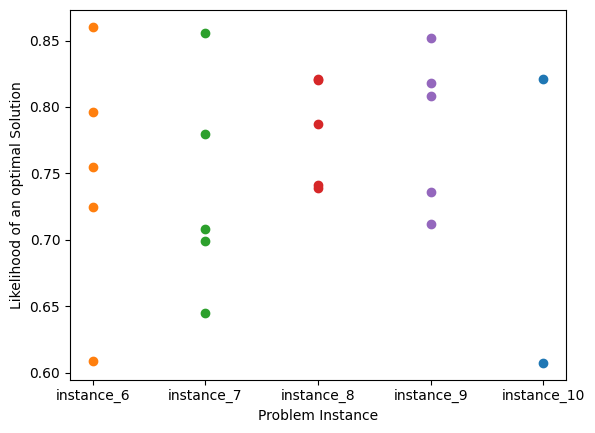

In [78]:
compare_measurement_likelihoods(evqe_loaded[15], p_opt, "Likelihood of an optimal Solution")

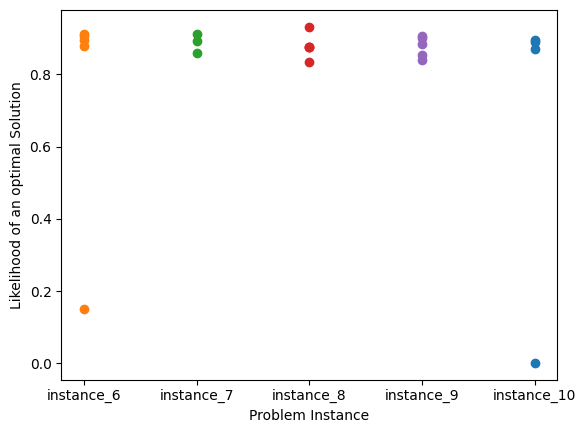

In [79]:
compare_measurement_likelihoods(vqe_loaded[15], p_opt, "Likelihood of an optimal Solution")

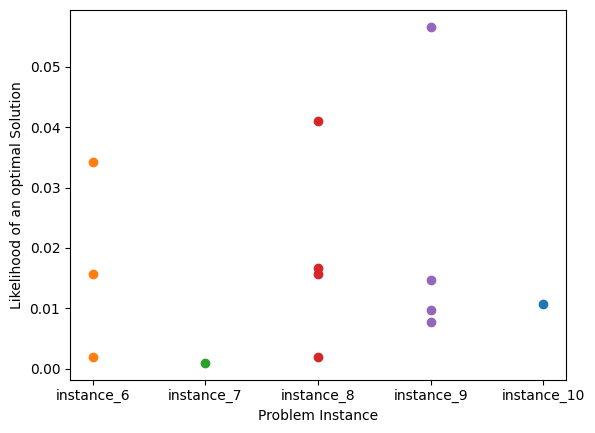

In [80]:
compare_measurement_likelihoods(qaoa_loaded[15], p_opt, "Likelihood of an optimal Solution")

In [81]:
from typing import Callable, Union, Optional

def compare_nexp(results: dict[int, Union[VQABenchmarkResult, EVQEBenchmarkResult]], metric: Callable[[Union[VQABenchmarkResult, EVQEBenchmarkResult]], Optional[int]], ylabel: Optional[str] = None):
    for instance, instance_results in results.items():
        y = [metric(res) for res in instance_results if metric(res) is not None]
        x = [instance]*len(y)
        plt.scatter(x, y)
    plt.xticks(ticks=list(results.keys()), labels=[f"instance_{i}" for i in results.keys()])
    
    plt.xlabel("Problem Instance")
    if ylabel is not None:
        plt.ylabel(ylabel)

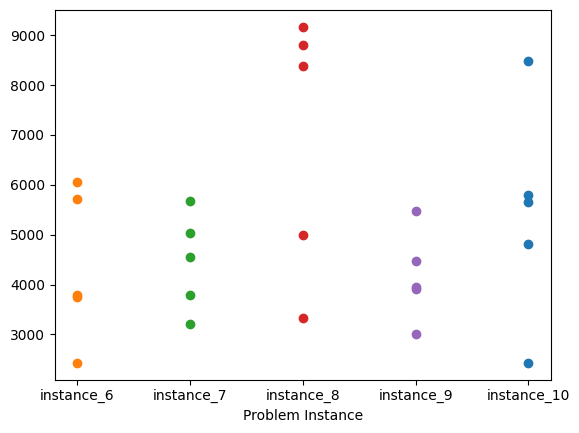

In [97]:
compare_nexp(evqe_loaded[18], nexp_best)

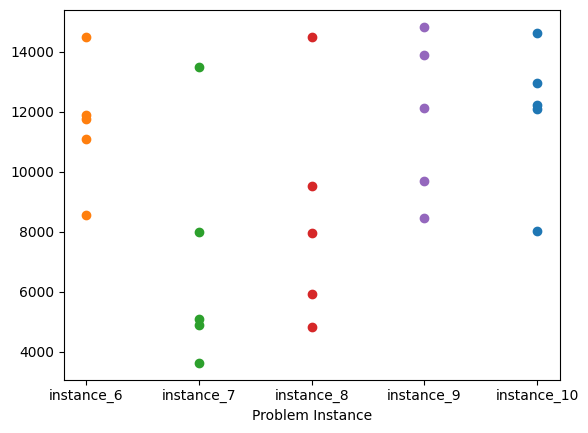

In [98]:
compare_nexp(vqe_loaded[18], nexp_best)

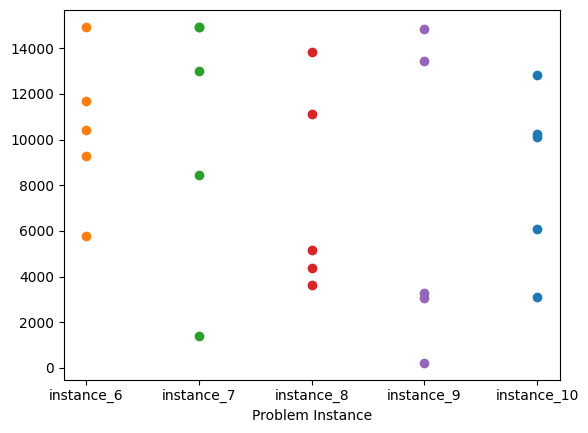

In [99]:
compare_nexp(qaoa_loaded[18], nexp_best)

## Compare Problem Sizes

In [357]:
from typing import Union, Optional
from numpy import mean, median, quantile
from matplotlib import patches
from pathlib import Path

def compare_success_ratio_over_problem_sizes(results: list[dict[int, dict[int, list[Union[VQABenchmarkResult, EVQEBenchmarkResult]]]]], problem_sizes: list[int], metric: Callable[[Union[VQABenchmarkResult, EVQEBenchmarkResult]], float], probability_boundary: float, algorithms_names: list[str], algorithm_offsets: list[float], algorithm_colors: list[str], ylabel: str, title: str, savepath: Optional[Path] = None):
    
    ratios: dict[str, list[float]] = {name: [] for name in algorithms_names}
    bar_positions: dict[str, list[float]] = {name: [] for name in algorithms_names}
    
    for problem_size in problem_sizes:
        for result, name, offset in zip(results, algorithms_names, algorithm_offsets):
            successful_count = 0
            all_count = 0
            
            for runresults in result[problem_size].values():
                for runresult in runresults:
                    probability = metric(runresult)
                    if probability >= probability_boundary:
                        successful_count += 1
                    all_count += 1
        
            ratios[name].append(successful_count / all_count)
            bar_positions[name].append(problem_size + offset)
    
    fig, ax = plt.subplots()
    
    patch_list = []
    for name, color in zip(algorithms_names, algorithm_colors):
        ax.bar(x=bar_positions[name], height=ratios[name], color=color, width=0.25)
        patch_list.append(patches.Patch(color=color, label=name))
    
    ax.set_xticks(problem_sizes)
    ax.set_xticklabels([f"{size} Qubits" for size in problem_sizes])
    ax.set_xlabel("Problem Size")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
    fig.legend(handles=patch_list, title="Algorithm", loc="center left", bbox_to_anchor=(0.9, 0.5))
    
    if savepath is not None:
        fig.savefig(savepath, bbox_inches="tight")

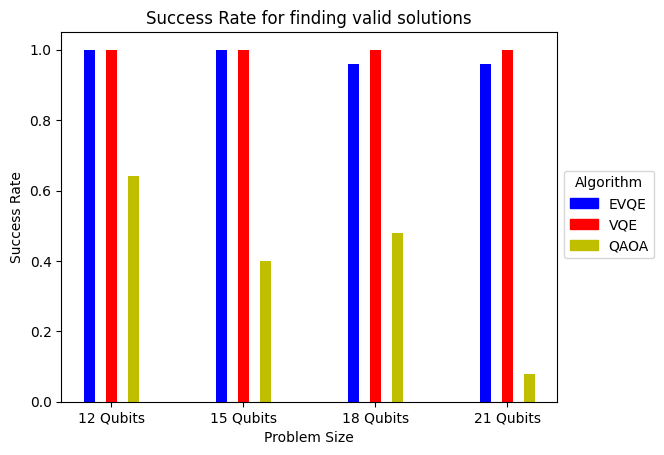

In [377]:
savepath = Path(Path(), "comparison_srate_val.pdf")
compare_success_ratio_over_problem_sizes([evqe_loaded, vqe_loaded, qaoa_loaded], [12, 15, 18, 21], p_val, 0.01, ["EVQE", "VQE", "QAOA"], [-0.5, 0, 0.5], ["b", "r", "y"], "Success Rate", "Success Rate for finding valid solutions", savepath=savepath)

In [21]:
from numpy import mean, quantile, median

def compare_pval_over_problem_sizes(evqe_result: dict[int, dict[int, list[EVQEBenchmarkResult]]], vqe_result: dict[int, dict[int, list[VQABenchmarkResult]]], qaoa_result: dict[int, dict[int, list[VQABenchmarkResult]]], problem_sizes: list[int]):
    
    evqe_values: dict[int, list[float]] = {size: [] for size in problem_sizes}
    for problem_size in problem_sizes:
        for instance in evqe_result[problem_size].keys():
            evqe_values[problem_size].extend(get_p_val(res) for res in evqe_result[problem_size][instance])
    
    vqe_values: dict[int, list[float]] = {size: [] for size in problem_sizes}
    for problem_size in problem_sizes:
        for instance in vqe_result[problem_size].keys():
            vqe_values[problem_size].extend(get_p_val(res) for res in vqe_result[problem_size][instance])
    
    qaoa_values: dict[int, list[float]] ={size: [] for size in problem_sizes}
    for problem_size in problem_sizes:
        for instance in qaoa_result[problem_size].keys():
            qaoa_values[problem_size].extend(get_p_val(res) for res in qaoa_result[problem_size][instance])
    
    evqe_offset = 0
    vqe_offset = 0.5
    qaoa_offset = -0.5
    
    fig, ax = plt.subplots()
    
    for problem_size in problem_sizes:
        evqemean = median(evqe_values[problem_size])
        lq, uq = quantile(evqe_values[problem_size], q=[0.25, 0.75])
        lq = evqemean - lq
        uq = uq - evqemean
        evqemin = min(evqe_values[problem_size])
        evqemax = max(evqe_values[problem_size])
        
        ax.errorbar(x=problem_size+evqe_offset, y=evqemean, yerr=[[lq], [uq]], fmt="o", mfc="b", mec="b", ecolor="b")
        
    
    for problem_size in problem_sizes:
        vqemean = median(vqe_values[problem_size])
        lq, uq = quantile(vqe_values[problem_size], q=[0.25, 0.75])
        lq = vqemean - lq
        uq = uq - vqemean
        evqemin = min(vqe_values[problem_size])
        evqemax = max(vqe_values[problem_size])
        
        ax.errorbar(x=problem_size+vqe_offset, y=vqemean, yerr=[[lq], [uq]], fmt="o", mfc="r", mec="r", ecolor="r")

    for problem_size in problem_sizes:
        qaoamean = median(qaoa_values[problem_size])
        lq, uq = quantile(qaoa_values[problem_size], q=[0.25, 0.75])
        lq = qaoamean - lq
        uq = uq - qaoamean
        evqemin = min(qaoa_values[problem_size])
        evqemax = max(qaoa_values[problem_size])
        
        ax.errorbar(x=problem_size+qaoa_offset, y=qaoamean, yerr=[[lq], [uq]], fmt="o", mfc="y", mec="y", ecolor="y")   
    
    ax.set_xticks(problem_sizes)

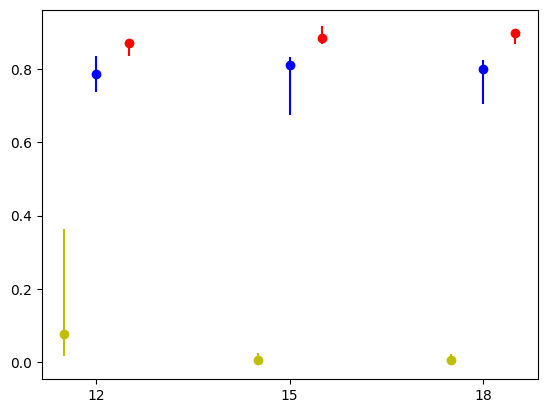

In [22]:
compare_pval_over_problem_sizes(evqe_loaded, vqe_loaded, qaoa_loaded, [12, 15, 18])

In [23]:
from numpy import mean, quantile

def compare_pval_over_problem_sizes_scatter(evqe_result: dict[int, dict[int, list[EVQEBenchmarkResult]]], vqe_result: dict[int, dict[int, list[VQABenchmarkResult]]], qaoa_result: dict[int, dict[int, list[VQABenchmarkResult]]], problem_sizes: list[int]):
    
    evqe_values: dict[int, list[float]] = {size: [] for size in problem_sizes}
    for problem_size in problem_sizes:
        for instance in evqe_result[problem_size].keys():
            evqe_values[problem_size].extend(get_p_opt(res) for res in evqe_result[problem_size][instance])
    
    vqe_values: dict[int, list[float]] = {size: [] for size in problem_sizes}
    for problem_size in problem_sizes:
        for instance in vqe_result[problem_size].keys():
            vqe_values[problem_size].extend(get_p_opt(res) for res in vqe_result[problem_size][instance])
    
    qaoa_values: dict[int, list[float]] ={size: [] for size in problem_sizes}
    for problem_size in problem_sizes:
        for instance in qaoa_result[problem_size].keys():
            qaoa_values[problem_size].extend(get_p_opt(res) for res in qaoa_result[problem_size][instance])
    
    evqe_offset = 0
    vqe_offset = 0.5
    qaoa_offset = -0.5
    
    for problem_size in problem_sizes:
        x = [problem_size+evqe_offset] * len(evqe_values[problem_size])
        plt.scatter(x, evqe_values[problem_size], c="b")
        
    
    for problem_size in problem_sizes:
        x = [problem_size+vqe_offset] * len(vqe_values[problem_size])
        plt.scatter(x, vqe_values[problem_size], c="r")

    for problem_size in problem_sizes:
        x = [problem_size+qaoa_offset] * len(qaoa_values[problem_size])
        plt.scatter(x, qaoa_values[problem_size], c="y")
    
    plt.xticks(problem_sizes)

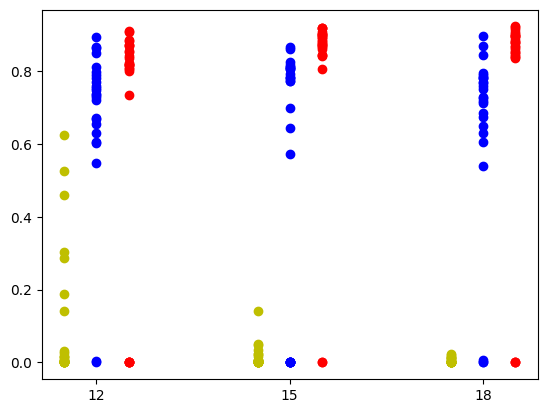

In [24]:
compare_pval_over_problem_sizes_scatter(evqe_loaded, vqe_loaded, qaoa_loaded, [12, 15, 18])

In [25]:
from numpy import mean, quantile

def compare_nexp_over_problem_sizes(evqe_result: dict[int, dict[int, list[EVQEBenchmarkResult]]], vqe_result: dict[int, dict[int, list[VQABenchmarkResult]]], qaoa_result: dict[int, dict[int, list[VQABenchmarkResult]]], problem_sizes: list[int]):
    
    evqe_values: dict[int, list[float]] = {size: [] for size in problem_sizes}
    for problem_size in problem_sizes:
        for instance in evqe_result[problem_size].keys():
            evqe_values[problem_size].extend(get_nexp_bounded(res, 100) for res in evqe_result[problem_size][instance])
    
    vqe_values: dict[int, list[float]] = {size: [] for size in problem_sizes}
    for problem_size in problem_sizes:
        for instance in vqe_result[problem_size].keys():
            vqe_values[problem_size].extend(get_nexp_bounded(res, 100) for res in vqe_result[problem_size][instance])
    
    qaoa_values: dict[int, list[float]] ={size: [] for size in problem_sizes}
    for problem_size in problem_sizes:
        for instance in qaoa_result[problem_size].keys():
            qaoa_values[problem_size].extend(get_nexp_bounded(res, 100) for res in qaoa_result[problem_size][instance])
    
    evqe_offset = 0
    vqe_offset = 0.5
    qaoa_offset = -0.5
    
    fig, ax = plt.subplots()
    
    for problem_size in problem_sizes:
        evqemean = median(evqe_values[problem_size])
        lq, uq = quantile(evqe_values[problem_size], q=[0.25, 0.75])
        lq = evqemean - lq
        uq = uq - evqemean
        evqemin = min(evqe_values[problem_size])
        evqemax = max(evqe_values[problem_size])
        
        ax.errorbar(x=problem_size+evqe_offset, y=evqemean, yerr=[[lq], [uq]], fmt="o", mfc="b", mec="b", ecolor="b")
        
    
    for problem_size in problem_sizes:
        vqemean = median(vqe_values[problem_size])
        lq, uq = quantile(vqe_values[problem_size], q=[0.25, 0.75])
        lq = vqemean - lq
        uq = uq - vqemean
        evqemin = min(vqe_values[problem_size])
        evqemax = max(vqe_values[problem_size])
        
        ax.errorbar(x=problem_size+vqe_offset, y=vqemean, yerr=[[lq], [uq]], fmt="o", mfc="r", mec="r", ecolor="r")

    for problem_size in problem_sizes:
        qaoamean = median(qaoa_values[problem_size])
        lq, uq = quantile(qaoa_values[problem_size], q=[0.25, 0.75])
        lq = qaoamean - lq
        uq = uq - qaoamean
        evqemin = min(qaoa_values[problem_size])
        evqemax = max(qaoa_values[problem_size])
        
        ax.errorbar(x=problem_size+qaoa_offset, y=qaoamean, yerr=[[lq], [uq]], fmt="o", mfc="y", mec="y", ecolor="y")   
    
    ax.set_xticks(problem_sizes)

In [170]:
from typing import Union
from numpy import mean, median, quantile

def compare_nexp_over_problem_sizes(results: list[dict[int, dict[int, list[Union[VQABenchmarkResult, EVQEBenchmarkResult]]]]], problem_sizes: list[int], metric: Callable[[Union[VQABenchmarkResult, EVQEBenchmarkResult]], Optional[int]], algorithms_names: list[str], algorithm_offsets: list[float], algorithm_colors: list[str], show_success_ratios: bool):
    
    fig, ax = plt.subplots()
    for problem_size in problem_sizes:
        for result, name, offset, color in zip(results, algorithms_names, algorithm_offsets, algorithm_colors):
            metric_values = []
            countall = 0
            for runresults in result[problem_size].values():
                metric_values.extend([metric(res) for res in runresults if metric(res) is not None])
                countall += len(runresults)
            
            if len(metric_values) < 1:
                continue
            
            success_ratio = len(metric_values) / countall
            mean_value = mean(metric_values)
            lq, uq = quantile(metric_values, q=[0.15, 0.85])
            lq = mean_value - lq
            uq = uq - mean_value
            
            ax.errorbar(x=problem_size+offset, y=mean_value, yerr=[[lq], [uq]], fmt="o", mfc=color, mec=color, ecolor=color)
            if show_success_ratios:
                ax.annotate(str(success_ratio), xy=(problem_size + offset, mean_value))
            

In [216]:
from typing import Union, Optional
from numpy import mean, median, quantile
from matplotlib import patches
from pathlib import Path

def compare_nexp_over_problem_sizes_boxplot(results: list[dict[int, dict[int, list[Union[VQABenchmarkResult, EVQEBenchmarkResult]]]]], problem_sizes: list[int], metric: Callable[[Union[VQABenchmarkResult, EVQEBenchmarkResult]], Optional[int]], algorithms_names: list[str], algorithm_offsets: list[float], algorithm_colors: list[str], ylabel: str, title: str, savepath: Optional[Path] = None):
    
    fig, ax = plt.subplots()
    datadict: dict[str, list[list[float]]] = {name: [] for name in algorithms_names}
    positiondict: dict[str, list[float]] = {name: [] for name in algorithms_names}
    for problem_size in problem_sizes:
        for result, name, offset in zip(results, algorithms_names, algorithm_offsets):
            metric_values = []
            countall = 0
            for runresults in result[problem_size].values():
                metric_values.extend([metric(res) for res in runresults if metric(res) is not None])
                countall += len(runresults)
            
            if len(metric_values) < 1:
                continue
            
            success_ratio = len(metric_values) / countall
            datadict[name].append(metric_values)
            positiondict[name].append(problem_size + offset)
    
    patch_list: list = []
    
    for name, color in zip(algorithms_names, algorithm_colors):
        alg_plot = ax.boxplot(x=datadict[name], positions=positiondict[name], widths=0.25, sym="", whis=100000)
        for k, v in alg_plot.items():
            plt.setp(alg_plot.get(k), color=color)
        patch_list.append(patches.Patch(color=color, label=name))
    
    ax.set_xticks(problem_sizes)
    ax.set_xticklabels([f"{size} Qubits" for size in problem_sizes])
    ax.set_xlabel("Problem Size")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    fig.legend(handles=patch_list, title="Algorithm", loc="center left", bbox_to_anchor=(0.9, 0.5))
    
    if savepath is not None:
        fig.savefig(savepath, bbox_inches="tight")

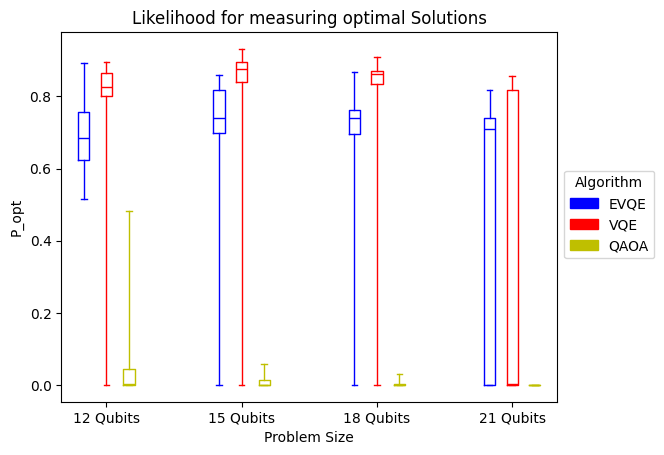

In [372]:
filepath = Path(Path(), "comparison_popt.pdf")
compare_nexp_over_problem_sizes_boxplot([evqe_loaded, vqe_loaded, qaoa_loaded], [12, 15, 18, 21], p_opt, ["EVQE", "VQE", "QAOA"], [-0.5, 0, 0.5], ["b", "r", "y"], "P_opt", "Likelihood for measuring optimal Solutions", filepath)

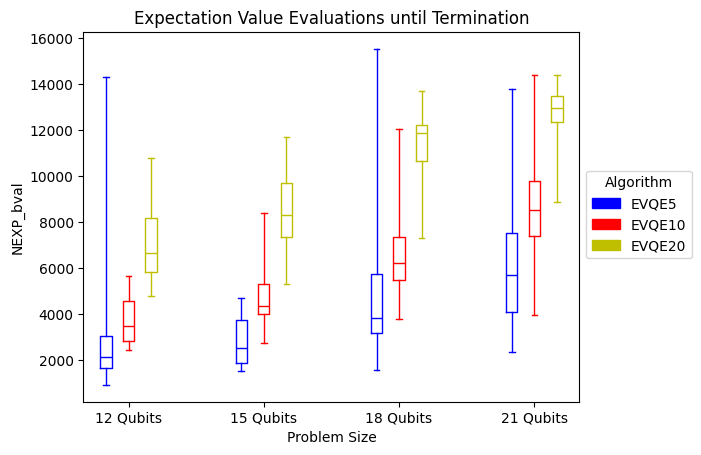

In [224]:
compare_nexp_over_problem_sizes_boxplot([evqe5_loaded, evqe_loaded, evqe20_loaded], [12, 15, 18, 21], nexp_term, ["EVQE5", "EVQE10", "EVQE20"], [-0.5, 0, 0.5], ["b", "r", "y"], "NEXP_bval", "Expectation Value Evaluations until Termination")